In [119]:
import os
import numpy as np

import pandas as pd
from pandas import DataFrame

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings("ignore")

#### Define system constants

In [120]:
# working directory
pwd: str = os.environ['HOME'] + '/work/assignment/assignment-13'
file: str = pwd + '/longley.csv'

#### Read the data file

In [121]:
df: DataFrame = pd.read_csv(file, sep=',')
print(df.head())

   Unnamed: 0  GNP.deflator      GNP  Unemployed  Armed.Forces  Population  \
0        1947          83.0  234.289       235.6         159.0     107.608   
1        1948          88.5  259.426       232.5         145.6     108.632   
2        1949          88.2  258.054       368.2         161.6     109.773   
3        1950          89.5  284.599       335.1         165.0     110.929   
4        1951          96.2  328.975       209.9         309.9     112.075   

   Year  Employed  
0  1947    60.323  
1  1948    61.122  
2  1949    60.171  
3  1950    61.187  
4  1951    63.221  


#### Data cleanup
- Removed the unnamed first column containing 'year' values.
- Made the 'Year' column as index. This column would thus be excluded from the clustering analysis, since it contains temporal data.

In [122]:
df_clean = df.drop(df.columns[[0]], axis=1)
df_clean.set_index('Year', inplace=True)
print(df_clean.head())
print(df_clean.describe())

      GNP.deflator      GNP  Unemployed  Armed.Forces  Population  Employed
Year                                                                       
1947          83.0  234.289       235.6         159.0     107.608    60.323
1948          88.5  259.426       232.5         145.6     108.632    61.122
1949          88.2  258.054       368.2         161.6     109.773    60.171
1950          89.5  284.599       335.1         165.0     110.929    61.187
1951          96.2  328.975       209.9         309.9     112.075    63.221
       GNP.deflator         GNP  Unemployed  Armed.Forces  Population  \
count     16.000000   16.000000   16.000000      16.00000   16.000000   
mean     101.681250  387.698438  319.331250     260.66875  117.424000   
std       10.791553   99.394938   93.446425      69.59196    6.956102   
min       83.000000  234.289000  187.000000     145.60000  107.608000   
25%       94.525000  317.881000  234.825000     229.80000  111.788500   
50%      100.600000  381.42700

#### Scaling the data - using StandardScalar function.
- Make the mean as 0, scale to unit variance (standard deviation)

In [123]:
scalar = StandardScaler()
df_scaled = pd.DataFrame(scalar.fit_transform(df_clean), columns=df_clean.columns)
print(df_scaled.head())
print(df_scaled.describe())

   GNP.deflator       GNP  Unemployed  Armed.Forces  Population  Employed
0     -1.787872 -1.594051   -0.925421     -1.508839   -1.457414 -1.468630
1     -1.261499 -1.332857   -0.959683     -1.707704   -1.305378 -1.233661
2     -1.290210 -1.347113    0.540111     -1.470253   -1.135969 -1.513330
3     -1.165795 -1.071288    0.174281     -1.419794   -0.964334 -1.214546
4     -0.524578 -0.610185   -1.209464      0.730628   -0.794184 -0.616389
       GNP.deflator           GNP    Unemployed  Armed.Forces    Population  \
count  1.600000e+01  1.600000e+01  1.600000e+01  1.600000e+01  1.600000e+01   
mean  -4.996004e-16 -1.110223e-16  5.551115e-16  1.110223e-16  9.436896e-16   
std    1.032796e+00  1.032796e+00  1.032796e+00  1.032796e+00  1.032796e+00   
min   -1.787872e+00 -1.594051e+00 -1.462561e+00 -1.707704e+00 -1.457414e+00   
25%   -6.848822e-01 -7.254609e-01 -9.339863e-01 -4.581148e-01 -8.367214e-01   
50%   -1.034800e-01 -6.516542e-02 -5.505414e-02  1.644538e-01 -9.212770e-02   
75%

#### K-means analysis to find out the optimal cluster count
- Runs the cluster analysis for cluster count range 1 - 10.
- Record the intra-cluster average distance

In [124]:
# k-means cluster analysis for 10 clusters         
seq_kmeans: range = range(1, 11)
dist_kmeans = np.zeros(10)

for k in seq_kmeans:
    model = KMeans(n_clusters=k)
    model.fit(df_scaled)
    predicted = model.predict(df_scaled)
    # euclidean distances of each data point with each centroid
    distances = cdist(df_scaled, model.cluster_centers_, 'euclidean')
    # euclidean distances of each data point with its centroid (min distance)
    min_distances = np.min(distances, axis=1)
    # avg euclidean distance across all data points against its centroid.
    avg_distance = sum(min_distances) / len(min_distances)
    dist_kmeans[k-1] = avg_distance

print('Mean distance for each cluster count =>', dist_kmeans)

Mean distance for each cluster count => [2.29421183 1.52341949 0.94771894 0.73356848 0.64587094 0.51370094
 0.42541074 0.37717041 0.30408328 0.23227448]


#### Plot the cluster counts against the average intra-cluster distance.

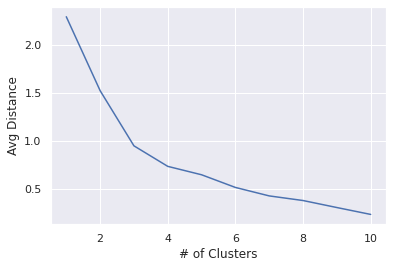

In [125]:
dist_kmeans_tuples: list = list(zip(seq_kmeans, dist_kmeans))
dist_kmeans_df: DataFrame = pd.DataFrame(dist_kmeans_tuples, columns=['# of Clusters', 'Avg Distance'])

sns.lineplot(x='# of Clusters', y='Avg Distance', data=dist_kmeans_df)

#### Build K-means model for the optimal cluster count
- Optimal cluster count is determined as 3 based on elbow method from the previous plot
- Add the cluster label as a column to the dataframe.

In [126]:
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(df_scaled)

df_cluster = df_scaled.copy()
df_cluster['Cluster'] = list(kmeans_model.labels_)
print(df_cluster.head())

   GNP.deflator       GNP  Unemployed  Armed.Forces  Population  Employed  \
0     -1.787872 -1.594051   -0.925421     -1.508839   -1.457414 -1.468630   
1     -1.261499 -1.332857   -0.959683     -1.707704   -1.305378 -1.233661   
2     -1.290210 -1.347113    0.540111     -1.470253   -1.135969 -1.513330   
3     -1.165795 -1.071288    0.174281     -1.419794   -0.964334 -1.214546   
4     -0.524578 -0.610185   -1.209464      0.730628   -0.794184 -0.616389   

   Cluster  
0        1  
1        1  
2        1  
3        1  
4        2  


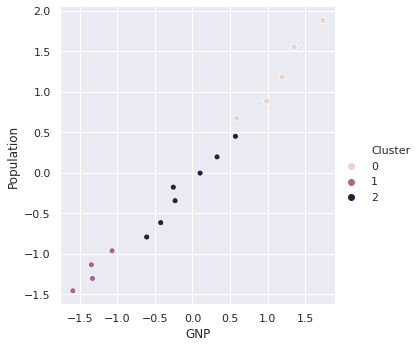

In [127]:
sns.set_palette('bright')
sns.relplot(x='GNP', y='Population', hue='Cluster', data=df_cluster)

#### Agglomerative Clustering
###### Complete Linkage method

{'icoord': [[5.0, 5.0, 15.0, 15.0], [25.0, 25.0, 35.0, 35.0], [10.0, 10.0, 30.0, 30.0], [55.0, 55.0, 65.0, 65.0], [45.0, 45.0, 60.0, 60.0], [20.0, 20.0, 52.5, 52.5], [75.0, 75.0, 85.0, 85.0], [95.0, 95.0, 105.0, 105.0], [80.0, 80.0, 100.0, 100.0], [125.0, 125.0, 135.0, 135.0], [115.0, 115.0, 130.0, 130.0], [145.0, 145.0, 155.0, 155.0], [122.5, 122.5, 150.0, 150.0], [90.0, 90.0, 136.25, 136.25], [36.25, 36.25, 113.125, 113.125]], 'dcoord': [[0.0, 0.4961785628529677, 0.4961785628529677, 0.0], [0.0, 1.1489409058733064, 1.1489409058733064, 0.0], [0.4961785628529677, 1.4998183142627366, 1.4998183142627366, 1.1489409058733064], [0.0, 0.5374327138376842, 0.5374327138376842, 0.0], [0.0, 2.265793635317777, 2.265793635317777, 0.5374327138376842], [1.4998183142627366, 3.032215450570408, 3.032215450570408, 2.265793635317777], [0.0, 0.5887841225973024, 0.5887841225973024, 0.0], [0.0, 0.6814230414139465, 0.6814230414139465, 0.0], [0.5887841225973024, 1.6010126939667366, 1.6010126939667366, 0.6814230

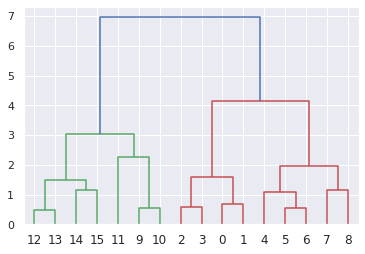

In [128]:
row_clusters_complete = linkage(df_scaled.values, method='complete', metric='euclidean')
row_dendr_complete = dendrogram(row_clusters_complete)
print(row_dendr_complete)

In [129]:
ac_complete = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
labels_complete = ac_complete.fit_predict(df_scaled.values)
print('Label assignment =>', labels_complete)

Label assignment => [2 2 2 2 1 1 1 1 1 0 0 0 0 0 0 0]


###### Ward Linkage method

{'icoord': [[5.0, 5.0, 15.0, 15.0], [25.0, 25.0, 35.0, 35.0], [10.0, 10.0, 30.0, 30.0], [55.0, 55.0, 65.0, 65.0], [75.0, 75.0, 85.0, 85.0], [60.0, 60.0, 80.0, 80.0], [45.0, 45.0, 70.0, 70.0], [105.0, 105.0, 115.0, 115.0], [95.0, 95.0, 110.0, 110.0], [145.0, 145.0, 155.0, 155.0], [135.0, 135.0, 150.0, 150.0], [125.0, 125.0, 142.5, 142.5], [102.5, 102.5, 133.75, 133.75], [57.5, 57.5, 118.125, 118.125], [20.0, 20.0, 87.8125, 87.8125]], 'dcoord': [[0.0, 0.5887841225973024, 0.5887841225973024, 0.0], [0.0, 0.6814230414139465, 0.6814230414139465, 0.0], [0.5887841225973024, 1.9892435596357945, 1.9892435596357945, 0.6814230414139465], [0.0, 0.4961785628529677, 0.4961785628529677, 0.0], [0.0, 1.1489409058733064, 1.1489409058733064, 0.0], [0.4961785628529677, 1.562763431147308, 1.562763431147308, 1.1489409058733064], [0.0, 1.9244116994349916, 1.9244116994349916, 1.562763431147308], [0.0, 0.5333229361394665, 0.5333229361394665, 0.0], [0.0, 1.0765798708805985, 1.0765798708805985, 0.5333229361394665

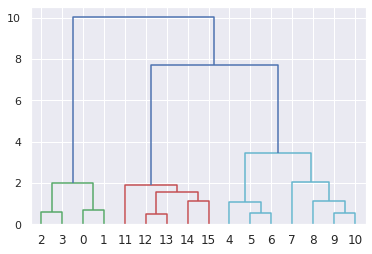

In [130]:
row_clusters_ward = linkage(df_scaled.values, method='ward', metric='euclidean')
row_dendr_ward = dendrogram(row_clusters_ward)
print(row_dendr_ward)

In [131]:
ac_ward = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels_ward = ac_ward.fit_predict(df_scaled.values)
print('Label assignment =>', labels_ward)

Label assignment => [1 1 1 1 0 0 0 0 0 0 0 2 2 2 2 2]


###### Comparison of Complete linkage & Ward linkage methods
- The dendrogram for Complete linkage indicates a potential cluster count of either 2, 3 or 4, & is not very differentiating in identifying the optimal number of clusters.
- The dendrogram for Ward linkage clearly highlights the potential cluster count as 3.
- There are minor differences in the cluster assignments between these 2 methods for few items (#9, #10, #11).
